In [1]:
import sys
sys.path.append('../src/')
from data_generator import *
from submetered_data import *
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from data_generator import *
import numpy as np
import pandas as pd
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.fontsize': 10})
%matplotlib inline
from scipy.spatial.distance import squareform
from sklearn.preprocessing import LabelEncoder, StandardScaler
from visual_functions import *
from transform_functions import *
fig_path="../paper/img/"
names = ['CFL','ILB','Waterkettle','Fan','AC','HairIron','LaptopCharger','SolderingIron','Fridge','Vacuum','CoffeeMaker','FridgeDefroster']

In [11]:
def read_events_labels(file1, file2, data_path='../../data/Data/'):
    a = pd.read_csv(data_path+file1,header=None)
    a = a.values

    b = pd.read_csv(data_path+file2,header=None)
    b = b.values

    events = {}
    labels = {}
    for index in range(len(a)):
        line = a[index]
        ev = [int(i) for i in line[0].strip().split(" ")]
        events[index] = ev

        line = b[index]
        ev = [int(i) for i in line[0].strip().split(" ")]
        labels[index] = ev
    return events, labels

def select_data_appliance_type(folder, appliance_id, data_path):
    file1 = folder + '_events'
    file2 = folder + '_labels'
    
    events, labels = read_events_labels(file1, file2, data_path)
    data_appliance_id = []
    files_appliance_id = []
    for index, e, l in zip(events.keys(), events.values(), labels.values()):
        if appliance_id not in l:
            continue
            
        ids_appl = np.where(np.array(l) == appliance_id)[0]
        events_appliance_id = np.array(e)[ids_appl]
        
        # Read the file.
        f = data_path+folder+'/'+str(index+1)
        #f = 'Data/'+folder+'/'+str(index+1)
        a = pd.read_csv(f,names=['current','voltage'])
        
        data_appliance_id += [a[i-1000:i+1000].values for i in events_appliance_id]
        files_appliance_id += [index+1 for i in events_appliance_id]
        
    return data_appliance_id, files_appliance_id
    
def select_zc(voltage):
    zero_crossing = np.where(np.diff(np.sign(voltage)))[0]
    
    if voltage[zero_crossing[0]+1] > 0:
        zero_crossing = zero_crossing[0:]
    else:
        zero_crossing = zero_crossing[1:]
        
    if len(zero_crossing) % 2 == 1:
        zero_crossing = zero_crossing[:-1]
        
    if zero_crossing[-1] + 250 >= len(voltage):
        zero_crossing = zero_crossing[:-2]
        
    return zero_crossing

def transform(data, on_event):
    c = np.empty((0,500))
    v = np.empty((0,500))
    
    for i, j in zip(data, on_event):
        current = i[:,0]
        voltage = i[:,1]

        zc = select_zc(voltage)

        before_event = np.concatenate([current[zc[0]:zc[0]+250],current[zc[1]:zc[1]+250]])
        after_event = np.concatenate([current[zc[-2]:zc[-2]+250],current[zc[-1]:zc[-1]+250]])

        if j:
            diff = after_event - before_event
            vtemp = np.concatenate([voltage[zc[-2]:zc[-2]+250],voltage[zc[-1]:zc[-1]+250]])
            
        else:
            diff = [before_event - after_event]
            vtemp = np.concatenate([voltage[zc[0]:zc[0]+250],voltage[zc[1]:zc[1]+250]])
            
        v = np.vstack((v,vtemp))
        c = np.vstack((c,diff))
            
    return c, v

data = []
labels = []
on_event = []
for i in range(1,2):
    t, f = select_data_appliance_type('FINALAGGREGATED', i, data_path='../../data/Data/')
    data += t
    labels += [i] * len(t)
    if i != 9:
        on_event += [1, 0] * int(len(t) / 2)
    else:
        on_event += [1, 1, 0] * int(len(t) / 3)

#current, voltage = transform(data, on_event)


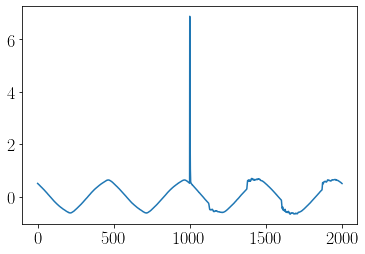

In [16]:
plt.plot(data[24][:,0])